#### 1. Import necessary libraries

In [604]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


#### 2. Data Collection/ Importing the dataset

In [606]:
# Step 2.1: Load the dataset
df_edu = pd.read_excel('dataset.xlsx')

# Preview the first few rows
print(df_edu.head)

# Print the number of rows and columns in the dataset
print("Number of entries in the dataset:", df_edu.shape)


<bound method NDFrame.head of           country_x code  Tertiary Percentage  ISCED5 Percentage  \
0         Argentina  ARG            95.447912          18.103877   
1         Australia  AUS           115.952037          25.407825   
2           Austria  AUT            86.475597          15.080255   
3           Belgium  BEL            80.138170           3.399620   
4            Brazil  BRA            55.136300           0.004350   
5            Canada  CAN            75.698825          17.629882   
6             Chile  CHL            93.101131          25.278138   
7             China  CHN            53.764914          22.995010   
8          Colombia  COL            54.976519          15.692163   
9            Cyprus  CYP            88.485329           8.480042   
10   Czech Republic  CZE            59.274594           0.204354   
11          Denmark  DNK            81.839762           9.341764   
12          Estonia  EST            74.231717                NaN   
13          Finlan

#### 3. Data Processing & Feature Engineering

In [608]:
# Step 3.1: Features/Variables selection — keeping only the columns needed for this analysis

# List of relevant columns we want to keep for clustering and plotting
columns_of_interest = [
    'InboundRatio', 'InternationalStudentsNO',
    'KOFPoGI', 'KOFEcGI', 'KOFSoGI',                  # 🌍 Globalisation Indices (Political, Economic & Social)
    'ISCED5 Percentage', 'ISCED6 Percentage',         # 🎓 Education Levels (Short-cycle tertiary, Bachelor)
    'ISCED7 Percentage', 'ISCED8 Percentage',         # 🎓 Education Levels (Masters, Doctoral)
    'top_50_count', 'top_100_count',                  # 🏆 University rankings (Top tiers)
    'top_500_count', 'top_1000_count',                # 🏆 Lower-tier rankings
    'WESP', 'country_x'                               # 🌐 World Economic Situation and Prospects 2021 + Country name
]

# Create a new DataFrame with only selected features/variables 
df_interest = df_edu[columns_of_interest]

# Print shape (rows, columns) of the selected features/variables 
print(df_interest.shape)  


(49, 15)


In [610]:
# ✅ Step 3.2: Calculate the missing values for selected features and drop

# Count of missing values per column
missing_count = df_interest[columns_of_interest].isnull().sum()

# Percentage of missing values per column 
missing_percentage = df_interest[columns_of_interest].isnull().mean() * 100

# Combine counts and percentages into one DataFrame
missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing (%)': missing_percentage.round(2)
})

# Display the summary
print("📊 Missing values summary (by column):")
display(missing_summary)

# Drop rows with missing values in the selected columns
df_interest_cleaned = df_interest.dropna(subset=columns_of_interest)

# Display row before and after cleaning
print(f"\nOriginal number of rows: {df_interest.shape[0]}")
print(f"Number of rows after dropping missing values: {df_interest_cleaned.shape[0]}")


📊 Missing values summary (by column):


,Missing Count,Missing (%)
InboundRatio,0,0.00
InternationalStudentsNO,0,0.00
KOFPoGI,0,0.00
KOFEcGI,0,0.00
KOFSoGI,0,0.00
ISCED5 Percentage,7,14.29
ISCED6 Percentage,1,2.04
ISCED7 Percentage,1,2.04
ISCED8 Percentage,1,2.04
top_50_count,0,0.00



Original number of rows: 49
Number of rows after dropping missing values: 42


### 4. Exploratory Data Analysis (EDA)

In [612]:
# Step 4.1: View Summary Statistics of the Cleaned Dataset and Selected Features

#  Basic descriptive statistics for all selected numeric columns
print("📈 Summary Statistics (Numeric Columns):\n")
summary_stats = df_interest_cleaned.describe().T.round(2)
display(summary_stats)


#  Data types for each column
print("\n🔎 Data Types:\n")
print(df_interest_cleaned.dtypes)

# Total number of missing values in the cleaned dataset
total_missing = df_interest_cleaned.isnull().sum().sum()
print(f"\n🚫 Total Missing Values in Cleaned Dataset: {total_missing}")

# Export data types
df_interest_cleaned.dtypes.to_frame(name="DataType").to_csv("Step4.1_DataTypes.csv")

# Export total missing value count to a text file
with open("Step4.1_TotalMissing.txt", "w") as f:
    f.write(f"Total Missing Values: {total_missing}")



📈 Summary Statistics (Numeric Columns):



,count,mean,std,min,25%,50%,75%,max
InboundRatio,42.0,9.37,8.02,0.22,3.55,7.80,12.46,35.29
InternationalStudentsNO,42.0,117317.38,183894.02,1546.00,22034.25,49007.00,114335.75,976562.00
KOFPoGI,42.0,84.95,13.51,29.00,79.50,89.50,93.00,98.00
KOFEcGI,42.0,71.98,12.99,42.00,64.00,76.50,82.00,90.00
KOFSoGI,42.0,79.98,9.36,59.00,73.25,83.00,87.00,91.00
ISCED5 Percentage,42.0,10.63,9.80,0.00,2.52,8.48,16.90,41.86
ISCED6 Percentage,42.0,45.24,13.08,12.32,38.85,44.47,54.24,68.24
ISCED7 Percentage,42.0,14.23,8.70,1.08,6.74,14.81,21.46,35.51
ISCED8 Percentage,42.0,2.10,1.35,0.00,0.80,2.09,2.89,5.15
top_50_count,42.0,1.10,3.26,0.00,0.00,0.00,0.00,19.00



🔎 Data Types:

InboundRatio               float64
InternationalStudentsNO      int64
KOFPoGI                      int64
KOFEcGI                      int64
KOFSoGI                      int64
ISCED5 Percentage          float64
ISCED6 Percentage          float64
ISCED7 Percentage          float64
ISCED8 Percentage          float64
top_50_count                 int64
top_100_count                int64
top_500_count                int64
top_1000_count               int64
WESP                        object
country_x                   object
dtype: object

🚫 Total Missing Values in Cleaned Dataset: 0


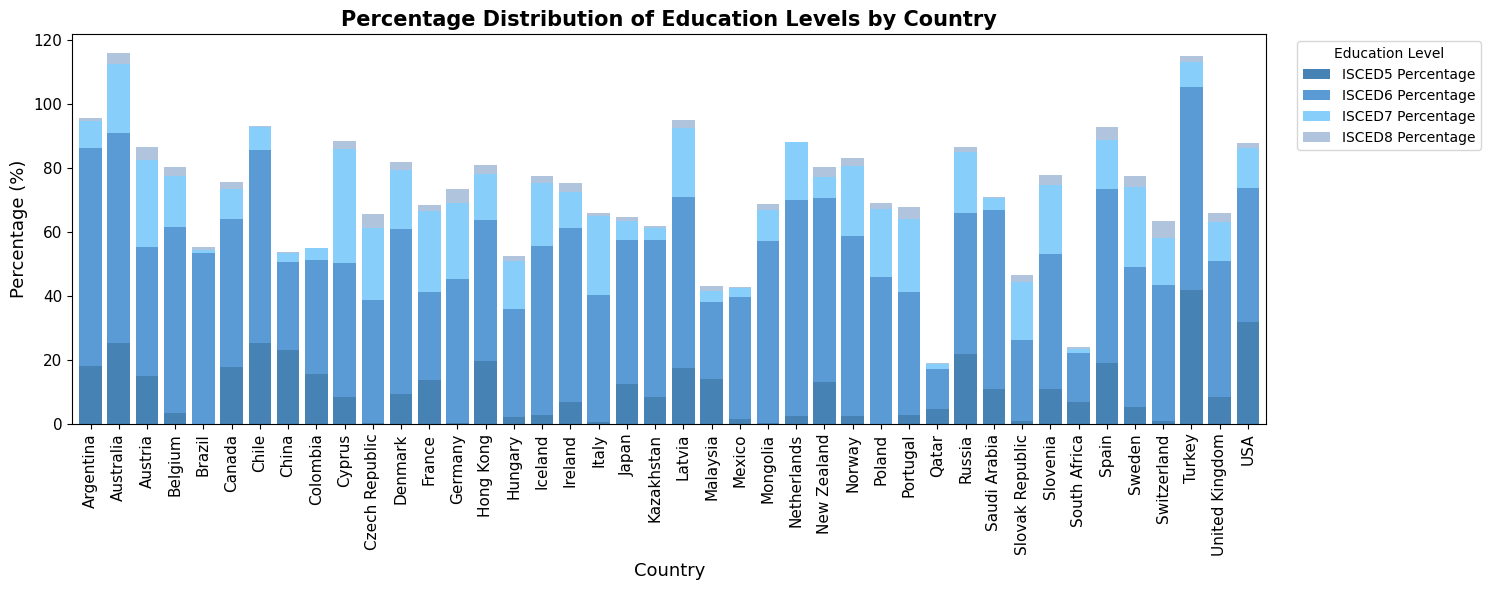

In [614]:
#Step 4.2: Visualize Education Levels by Country using a Stacked Bar Chart
percentage_cols = ['ISCED5 Percentage', 'ISCED6 Percentage', 'ISCED7 Percentage', 'ISCED8 Percentage']
df_stacked = df_interest_cleaned[['country_x'] + percentage_cols].set_index('country_x')

# Create plot
fig, ax = plt.subplots(figsize=(15, 6))

# Steel blue color palette (from dark to light shades)
colors = ['#4682B4', '#5B9BD5', '#87CEFA', '#B0C4DE']  # steel blue tones

# Plot stacked bar chart
df_stacked.plot(kind='bar', stacked=True, ax=ax, width=0.8, color=colors)

# Aesthetics
ax.set_title("Percentage Distribution of Education Levels by Country", fontsize=15, fontweight='bold')
ax.set_ylabel("Percentage (%)", fontsize=13)
ax.set_xlabel("Country", fontsize=13)

# Tick label font size and tick mark styling
ax.tick_params(axis='x', labelsize=11, labelrotation=90)
ax.tick_params(axis='y', labelsize=11)

# Move legend outside
ax.legend(title="Education Level", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


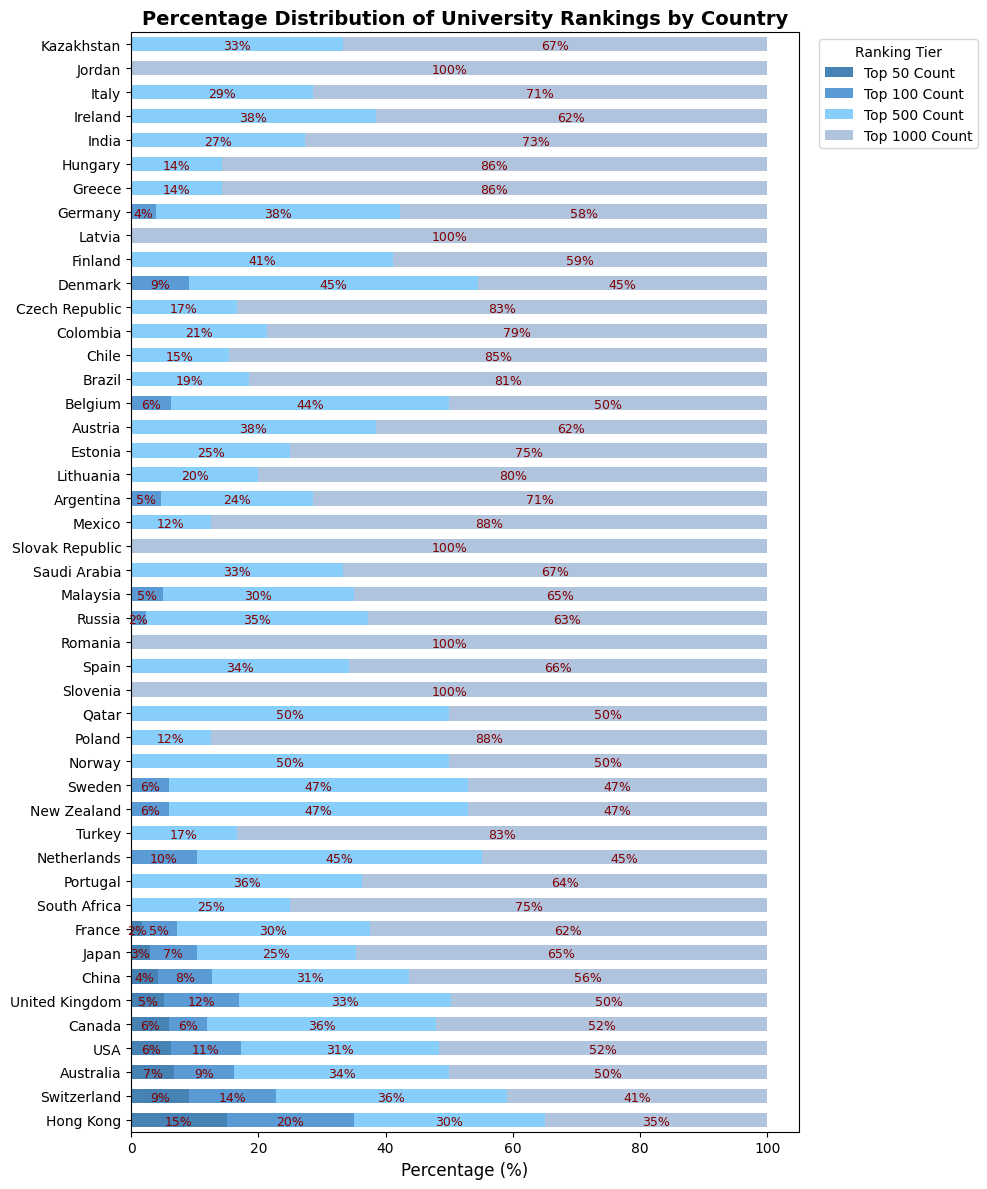

In [616]:
#Step 4.3: Visualize University Rankings by Country using a Stacked Bar Chart

# Ranking columns
ranking_cols = ['top_50_count', 'top_100_count', 'top_500_count', 'top_1000_count']

# Filter valid rows
df_ranked = df[['country_x'] + ranking_cols].copy()
df_ranked = df_ranked.dropna(subset=ranking_cols, how='all')
df_ranked = df_ranked[df_ranked[ranking_cols].sum(axis=1) > 0].copy()

# Calculate percentages
df_ranked['total'] = df_ranked[ranking_cols].sum(axis=1)
for col in ranking_cols:
    df_ranked[col + '_pct'] = (df_ranked[col] / df_ranked['total']) * 100

# Sort by top_50 percentage
df_ranked = df_ranked.sort_values(by='top_50_count_pct', ascending=False)

# Steel blue color palette
colors = ['#4682B4', '#5B9BD5', '#87CEFA', '#B0C4DE']  # dark to light

# Plot
fig, ax = plt.subplots(figsize=(10, 12))
y = np.arange(len(df_ranked))
left = np.zeros(len(df_ranked))

for i, col in enumerate(ranking_cols):
    pct_col = col + '_pct'
    bars = ax.barh(y, df_ranked[pct_col], left=left, height=0.6,
                   label=col.replace('_', ' ').title(), color=colors[i])
    
    # Percentage labels
    for j, val in enumerate(df_ranked[pct_col]):
        if val > 0:
            ax.text(left[j] + val / 2, y[j], f"{val:.0f}%", ha='center', va='center_baseline',
                    fontsize=9, color='maroon')

    left += df_ranked[pct_col].values


# Axis labels and title
ax.set_yticks(y)
ax.set_yticklabels(df_ranked['country_x'], fontsize=12)
ax.set_xlabel("Percentage (%)", fontsize=12)
ax.set_title("Percentage Distribution of University Rankings by Country",
             fontsize=14, fontweight='bold')

# Tick label font size and tick mark size
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Add space between bars
ax.set_ylim(-0.5, len(df_ranked) - 0.5)

# Legend outside
ax.legend(title="Ranking Tier", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


## 5. Data Analysis – Unsupervised Machine Learning Algorithm: Clustering Analysis

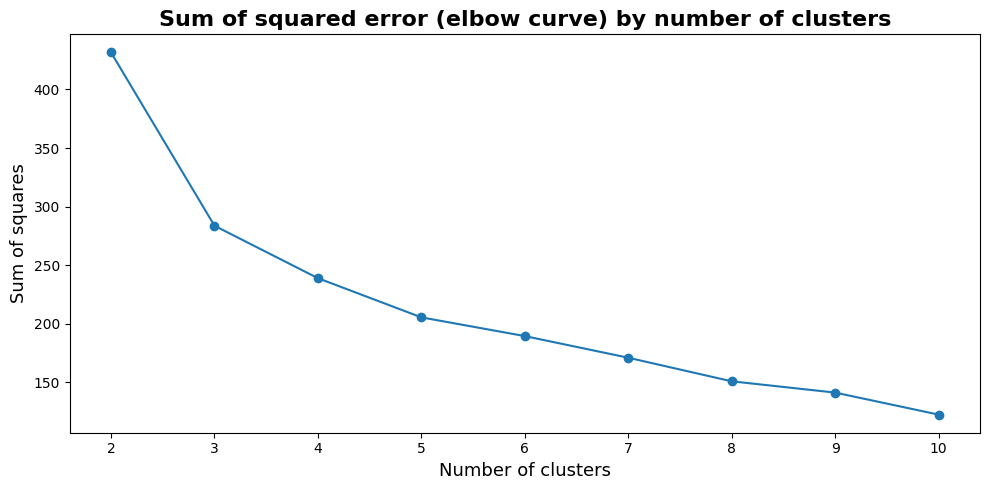

In [664]:
# Step 5.1: K-Means Clustering - to choose the number of clusters (k), we chose to use the Elbow Method in this analysis.

#Drop non-numeric columns
X = df_interest_cleaned.drop(['country_x', 'WESP'], axis=1)

# Step 2: Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Step 3: Define the WCSS function
def wcss(x, kmax):
    wcss_s = []
    for k in range(2, kmax + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(x)
        wcss_s.append(kmeans.inertia_) 
    return wcss_s

# Step 4: Plot the elbow curve
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
kmax = 10
ax.plot(range(2, kmax + 1), wcss(X_std, kmax), marker='o')
ax.set_xlabel('Number of clusters', fontsize=13)
ax.set_ylabel('Sum of squares', fontsize=13)
ax.set_title('Sum of squared error (elbow curve) by number of clusters', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


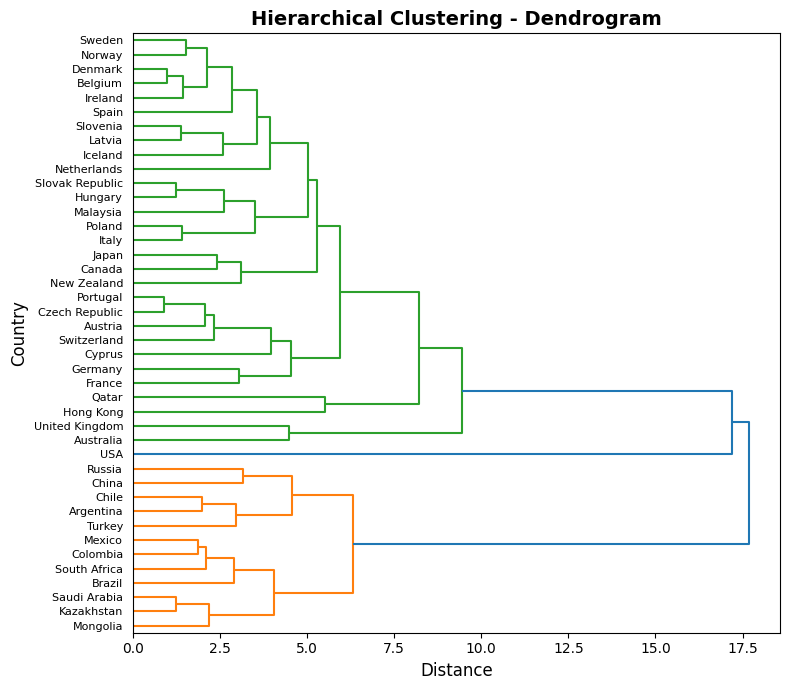

In [666]:
##Step 5.1: Data Modeling – Hierarchical Clustering with dendrogram analysis

# Step 1: Drop non-numeric columns
X = df_interest_cleaned.drop(['country_x', 'WESP'], axis=1)

# Step 2: Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Step 3: Perform hierarchical clustering
Z = linkage(X_std, method='ward')

# Step 4: Plot the dendrogram
plt.figure(figsize=(8, 7))
dend = dendrogram(
    Z,
    orientation='right',
    labels=df_interest_cleaned['country_x'].tolist()
)

plt.title('Hierarchical Clustering - Dendrogram', fontsize=14, fontweight='bold')
plt.xlabel('Distance', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()




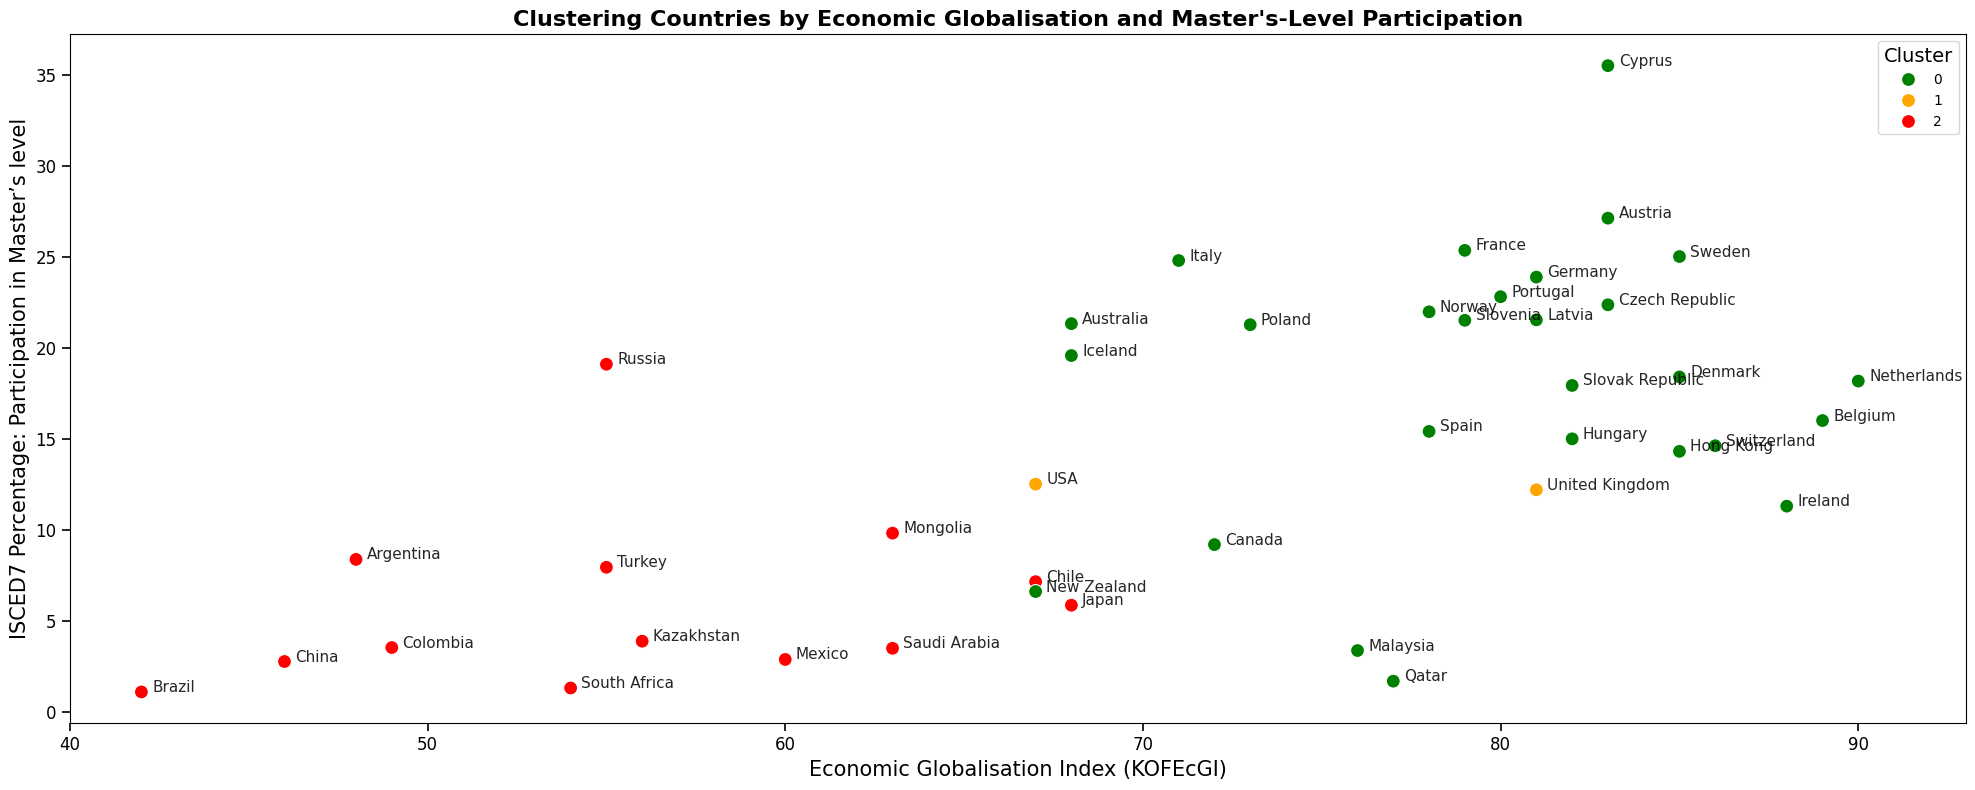

In [593]:
#Step 5.3: Cluster Visualisation with Scatter Plot

# STEP 1: Standardize numeric features for clustering
X = df_interest_cleaned.drop(['country_x', 'WESP'], axis=1)  # Exclude non-numeric or ID columns
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# STEP 2: Apply K-Means Clustering with k=2
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_std)
df_interest_cleaned['Cluster'] = kmeans.labels_  # Add cluster label to the dataset

# STEP 3: Visualize clusters using a scatter plot
plt.figure(figsize=(20, 8))

sns.scatterplot(
    x='KOFEcGI',  # Economic Globalisation Index
    y='ISCED7 Percentage',  # Participation in Master's level education
    hue='Cluster',          # Color by cluster
    data=df_interest_cleaned,
    palette=["green", "orange", "red"],
    s=100  # Dot size
)

# Set axis labels and plot title
plt.xlabel('Economic Globalisation Index (KOFEcGI)', fontsize=15)
plt.ylabel("ISCED7 Percentage: Participation in Master’s level", fontsize=15)
plt.title("Clustering Countries by Economic Globalisation and Master's-Level Participation", 
          fontsize=16, fontweight='bold')

# Extend x-axis slightly to avoid label overlap
plt.xlim(df_interest_cleaned['KOFEcGI'].min() - 2,
         df_interest_cleaned['KOFEcGI'].max() + 3)

# Tick label font size and tick mark styling
plt.tick_params(axis='x', labelsize=12, length=6, width=1.2)
plt.tick_params(axis='y', labelsize=12, length=6, width=1.2)

# Add country name labels beside each point
for i in range(len(df_interest_cleaned)):
    plt.text(
        df_interest_cleaned['KOFEcGI'].iloc[i] + 0.3,
        df_interest_cleaned['ISCED7 Percentage'].iloc[i],
        df_interest_cleaned['country_x'].iloc[i],
        fontsize=11,
        alpha=0.85,
        color='black'
    )

# Legend
plt.legend(title='Cluster', title_fontsize=14)
plt.tight_layout()
plt.show()
